# Outlier Detection

This notebook will walk you through a workflow for outlier detection.

## TOC

 * [Detecting outlier jobs](#detect-outlier-jobs-study-1)
  * [Getting comparable jobs](#comparable-jobs)
  * [outlier detection using other features](#using-other-features)
  * [wildcard features](#wildcard-features)
  * [Multivariate Outlier Detection](#multivariate-eod)
    * [Trained Models](#trained-models)
  * [Standardization and Normalization](#standard-norm)
  * [Root Cause Analysis (RCA)](#rca-job)
 * [Detecting outlier operations](#detect-outlier-ops)
    * [RCA for operations](#rca-ops)
 * [Feature Importance and Reduction (PCA)](#pca)
    * [PCA Feature Ranking](#pca-feature-rank)
    * [PCA Feature Plots](#pca-feature-plots)
    * [PCA-based Trained Models](#trained-models-pca)
 * [EPMT Explore API](#epmt-exp-explore)



# <a name="detect-outlier-jobs-study-1">Detecting outlier jobs</a>

In this example we will study a variety of approaches to indentify outlier
jobs from among set of jobs within an *experiment*.

We will start with using univariate classifiers, and then work our way to 
multivariate classification techniques. Finally, we will look at PCA (principal
component analysis) as means to reduce data dimensionality and to aid both
in data visualization and root cause analysis (RCA). For our studies we will use
the *epmt outlier detection* and the *epmt query* API. 

We will use data from the `ESM4_hist-piAer_D1` experiment.


### Requirements

You will need to import data:
```
# use the SQLAlchemy ORM and a SQLite backend. You may instead choose
# to use the postgresql backend (settings_pg_localhost_sqlalchemy.py)
$ cp preset_settings/settings_sqlite_localfile_sqlalchemy.py settings.py

# Backup earlier database if it exists
$ mv ~/EPMT_DB.sqlite ~/EPMT_DB.sqlite.backup

# now import the needed job files into the DB
# We load jobs from 4 time segments: 1854, 1859, 1864, 1869
# As the entire ESM4_hist-piAer_D1 experiment has a lot of data
# -- more than needed here --
# and we also want comparable jobs for outlier detection we will also
# selectively load jobs for a single component -- atmos_cmip.
# This is the most important (longest by duration) in the experiment
# The jobs will take about 20-25 minutes to load.
$ epmt submit test/data/outliers_nb/*.tgz

```

In [1]:
# epmt_query contains the EPMT Query API
import epmt_query as eq
# epmt_outliers contains the EPMT Outlier Detection API
import epmt_outliers as eod
# epmt_stat contains statistical functions
import epmt_stat as es
import pandas as pd
import numpy as np

In [2]:
jobs = eq.get_jobs(tags='exp_name:ESM4_hist-piAer_D1', fmt='terse')
len(jobs)

127

## <a name="comparable-jobs">Getting Comparable Jobs</a>
Not all these jobs are comparable to each other (since they have
different components. We need to partition the jobs into sets that are of
the same component.

The function below returns a list sorted in decreasing order of cumulative duration
for the jobs of the component. This way we know that first tuple represents the
component of the longest duration.

In [3]:
comp_job_parts = eq.comparable_job_partitions(jobs)
comp_job_parts

[(('ESM4_hist-piAer_D1', 'atmos_cmip'),
  ['2444931',
   '2460340',
   '2494089',
   '2501763',
   '2546910',
   '2549352',
   '2557075',
   '2568088',
   '2577413',
   '2579660',
   '2581160',
   '2587725',
   '2600696',
   '2605559',
   '2621360',
   '2626358',
   '2628013',
   '2632680',
   '2641421']),
 (('ESM4_hist-piAer_D1', 'aerosol_cmip'),
  ['2444929', '2460338', '2494087', '2501761']),
 (('ESM4_hist-piAer_D1', 'tracer_level'),
  ['2444963', '2460367', '2494114', '2501788']),
 (('ESM4_hist-piAer_D1', 'land_cmip'),
  ['2444941', '2460345', '2494093', '2501767']),
 (('ESM4_hist-piAer_D1', 'atmos'),
  ['2444930', '2460339', '2494088', '2501762']),
 (('ESM4_hist-piAer_D1', 'atmos_level'),
  ['2444933', '2460342', '2494091', '2501765']),
 (('ESM4_hist-piAer_D1', 'land_dust'),
  ['2444942', '2460346', '2494094', '2501768']),
 (('ESM4_hist-piAer_D1', 'river'),
  ['2444962', '2460366', '2494113', '2501787']),
 (('ESM4_hist-piAer_D1', 'ocean_inert_month_1x1deg'),
  ['2444957', '2460361

You may notice that for `atmos_cmip` we have a number of jobs, while for
the other components we have only 4 jobs each. That's because we loaded
all the `atmos_cmip` jobs in the database, but only the first four time
segments for the other components. 

While we have some powerful functions and commands to speed up
the process let's do some manual digging first so we have a better
feel of the process. Let's focus on the first component: `atmos_cmip`.
Let's see if the jobs of `atmos_cmip` have any outliers.

In [4]:
# As a first pass let's see whether the outliers can be auto-detected
atmos_cmip_jobs = eq.get_jobs(tags='exp_name:ESM4_hist-piAer_D1;exp_component:atmos_cmip', fmt='terse')
(df, _) = eod.detect_outlier_jobs(atmos_cmip_jobs)
df

,jobid,cpu_time,duration,num_procs
0,2444931,0,0,3
1,2460340,0,3,1
2,2494089,0,0,0
3,2501763,0,0,0
4,2546910,0,0,1
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0
9,2579660,1,0,1


In the dataframe above the number of outlier detection methods that considered the job to be an outlier based on a particular feature. So the higher the score, the greater the probability of the job being an outlier. 

Let's sort the dataframe by the sum of the scores across the features.

In [5]:
df['score'] = 0
df['score'] = df.sum(axis=1)
sorted_df = df.sort_values('score', ascending=False)
sorted_df[['jobid', 'cpu_time', 'duration', 'num_procs']]

,jobid,cpu_time,duration,num_procs
1,2460340,0,3,1
0,2444931,0,0,3
13,2605559,3,0,0
9,2579660,1,0,1
4,2546910,0,0,1
11,2587725,0,0,1
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0


Based on the scoring it seems `2460340`, `244931` and `2605559` might be outliers.

We use three methods -- IQR (interquartile range), MADZ (modified adjusted z-score) and Z-score -- as the default methods for univariate outlier detection. These are specified, along with their thresholds, in `settings.py`. You can choose different defaults by changing `univariate_classifiers` in `settings.py`. You may also use the `methods` argument to specify different outlier detection methods when calling `detect_outlier_jobs`.

### <a name="using-other-features">Outlier detection using other metrics</a>
By default, `detect_outlier_jobs` uses `num_procs`, `duration` and `cpu_time`
as the **features** for outlier detection. Often times we care most about `duration`
(wallclock time). At other times we care about the actual CPU cycles, represented by
`cpu_time`. `num_procs` represents the number of processes in the job, and can often
help in outlier detection in case of process retries. So, you will normally be
satisfied with our default feature choices. However, if one desires one can pass the
`features` argument to the call to select some other features. You can also pass the wildcard
`'*'` to select all available features.

In [6]:
# Let's get the list of availabe features
eq.get_features(atmos_cmip_jobs)

['PERF_COUNT_SW_CPU_CLOCK',
 'cancelled_write_bytes',
 'cmajflt',
 'cminflt',
 'cpu_time',
 'cstime',
 'cutime',
 'delayacct_blkio_time',
 'duration',
 'exitcode',
 'guest_time',
 'inblock',
 'invol_ctxsw',
 'majflt',
 'minflt',
 'num_procs',
 'num_threads',
 'outblock',
 'processor',
 'rchar',
 'rdtsc_duration',
 'read_bytes',
 'rssmax',
 'submit',
 'syscr',
 'syscw',
 'systemtime',
 'time_oncpu',
 'time_waiting',
 'timeslices',
 'updated_at',
 'usertime',
 'vol_ctxsw',
 'wchar',
 'write_bytes']

For a description of these events you can refer to `docs/metrics.md` in the EPMT install.

It's tedious to type out all the features, so we support <a name="wildcard-features">wildcard features</a>
as shown in the following examples.

In [7]:
(df, _) = eod.detect_outlier_jobs(atmos_cmip_jobs, features='*')
df

,jobid,PERF_COUNT_SW_CPU_CLOCK,cancelled_write_bytes,cmajflt,cminflt,cpu_time,cstime,cutime,delayacct_blkio_time,duration,...,syscr,syscw,systemtime,time_oncpu,time_waiting,timeslices,usertime,vol_ctxsw,wchar,write_bytes
0,2444931,0,2,0,3,0,0,0,0,0,...,3,3,0,0,0,3,0,3,3,3
1,2460340,0,0,0,0,0,0,1,0,3,...,1,2,0,0,1,0,0,0,0,0
2,2494089,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2501763,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2546910,0,0,2,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
5,2549352,0,0,0,0,0,1,0,0,0,...,0,0,2,0,0,0,0,0,0,0
6,2557075,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2568088,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,2577413,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
9,2579660,1,0,0,0,1,0,1,0,0,...,0,0,1,1,1,0,1,0,0,0


In [8]:
# As there are a lot of features let us get a composite score for each jobid across all features
df['score'] = 0
df['score'] = df.sum(axis=1)
df[['jobid', 'score']].sort_values('score', ascending=False)

,jobid,score
0,2444931,46
13,2605559,37
1,2460340,14
4,2546910,13
9,2579660,13
16,2628013,10
17,2632680,7
11,2587725,6
14,2621360,6
5,2549352,5


Judging by these outlier scores it seems `2605559` and `2444931` are prime candidates to be outliers, while `2460340` might be slightly less so. 

You might be wondering why using multiple features increased the likelihood of `2605559` and `2444931` in contrast to `2460340`. One intuition for that is that jobs that are considered by to be outliers by features such as `num_procs` or `cpu_time`, will end up getting a boost in scores as a number of features are strontly correlated to these features. In contrast, jobs that are classified as outliers on the basis of `duration` will not get that boost, since only `rdtsc_duration` is strongly correlated to `duration`. Most of the other features are not. This will also become apparent when we consider *feature ranking using PCA* in a later section.

## <a name="multivariate-eod">Multivariate Outlier Detection</a>

We will now look at outlier detection using multivariate classifiers. Multivariate
classifiers look at multiple features *simultaneously* while doing outlier detection.
They may often perform better than univariate classifiers.

### <a name="trained-models">Trained (reference) models</a>

Multivariate classifiers require a *trained model*. For that we need to get a
version of truth. In other words, which jobs are representative. 

First let's run univariate classifiers to determine which jobs are inliers. We
will use a subset of the inliers to create a trained model.

In [9]:
df, _ = eod.detect_outlier_jobs(atmos_cmip_jobs)
df

,jobid,cpu_time,duration,num_procs
0,2444931,0,0,3
1,2460340,0,3,1
2,2494089,0,0,0
3,2501763,0,0,0
4,2546910,0,0,1
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0
9,2579660,1,0,1


Now let's select those jobs that are not showing outliers for any features.

In [10]:
df['score'] = 0
df['score'] = df.sum(axis=1)
inliers_df = df[df.score == 0][['jobid', 'cpu_time', 'duration', 'num_procs']]
inliers_df

,jobid,cpu_time,duration,num_procs
2,2494089,0,0,0
3,2501763,0,0,0
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0
10,2581160,0,0,0
12,2600696,0,0,0
14,2621360,0,0,0
15,2626358,0,0,0


Let's select a random subset of 4 jobs from among these to create a trained model. 

Here we use the default features `['cpu_time', 'duration', 'num_procs']` while creating the trained model. We could instead specify `features`. As before, we can use the wildcard (`'*'`) to specify all available features.

In [11]:
rand = np.random.RandomState(42)
num_inliers = len(inliers_df)
selected_indices = np.sort(rand.choice(num_inliers, 4, replace=False))
selected_indices

array([ 0,  8,  9, 11])

In [12]:
model_jobs = list(inliers_df.jobid.iloc[selected_indices].values)
model_jobs

['2494089', '2621360', '2626358', '2632680']

In [13]:
r = eq.create_refmodel(model_jobs, methods=es.mvod_classifiers())
r

{'jobs': ['2494089', '2621360', '2626358', '2632680'],
 'name': None,
 'tags': {},
 'op_tags': [],
 'computed': {'pyod.models.mcd': {'cpu_time,duration,num_procs': [2.8031,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0, 36262018973.0, 104779.0],
     [13561761036.0, 21122417938.0, 104779.0],
     [15447854905.0, 23934831859.0, 104779.0]]]},
  'pyod.models.cof': {'cpu_time,duration,num_procs': [1.1836,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0, 36262018973.0, 104779.0],
     [13561761036.0, 21122417938.0, 104779.0],
     [15447854905.0, 23934831859.0, 104779.0]]]},
  'pyod.models.hbos': {'cpu_time,duration,num_procs': [6.2109,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0, 36262018973.0, 104779.0],
     [13561761036.0, 21122417938.0, 104779.0],
     [15447854905.0, 23934831859.0, 104779.0]]]},
  'pyod.models.pca': {'cpu_time,duration,num_procs': [43.0159,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0

The trained model is saved in the database. 

We use number of multivariate classifiers from [PYOD](https://pyod.readthedocs.io/en/latest/). 
If you are unfamiliar with outlier detection using PYOD, you might want to read [this tutorial](https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9).

Now let us use this model to do outlier detection over all the jobs from this component.

In [14]:
df, model_scores = eod.detect_outlier_jobs(atmos_cmip_jobs, methods=es.mvod_classifiers(), trained_model=r['id'])
df.sort_values('outlier', ascending=False)

,jobid,outlier
1,2460340,4
0,2444931,2
16,2628013,2
9,2579660,2
4,2546910,1
5,2549352,1
3,2501763,1
11,2587725,1
13,2605559,1
6,2557075,0


Multivariate outlier detection seems to suggest `2460340` is most likely to be an outlier, while
`244931` to a lesser extent, and `2605559` even less. One reason that this differs from
multimode univariate detection with wildcard features is that, with wildcard features we give `duration` a far lower weightage than features strongly correlated with `cpu_time` and `num_procs`, which form a bulk of the features. This tends to make `2460340` be labelled more as an outlier when we use only three features, one of which is `duration`.

Another aspect governing the outlier detection is our selection of `model_jobs`, as what is classified as an outlier and what is not, depends on the selection of jobs for the trained model. 

### <a name="standard-norm">Standardization and Normalization</a>

The features we passed for outlier detection were not scaled prior to outlier
detection. Scaling can have important ramifications for outlier detection.

We do perform standard scaling as part of PCA (covered later), and have
helper functions to support standardization and normalization.

In [15]:
rand = np.random.RandomState(42)
# randn gives a normal distribution of 0 mean and 1 sigma
# We scale it by 1.5 and offset the mean by 5. This changes
# the mean and sigma
X = rand.randn(10,2) * 1.5 + 5
X

array([[5.74507123, 4.79260355],
       [5.97153281, 7.28454478],
       [4.64876994, 4.64879456],
       [7.36881922, 6.15115209],
       [4.29578842, 5.81384007],
       [4.30487346, 4.30140537],
       [5.36294341, 2.13007963],
       [2.41262325, 4.15656871],
       [3.48075332, 5.471371  ],
       [3.63796389, 2.88154445]])

In [16]:
# normalization does min-max scaling. Here we do on each of the columns
# independently
norm_X = es.normalize(X)
norm_X

array([[0.67238019, 0.51654708],
       [0.71807281, 1.        ],
       [0.45118206, 0.48864719],
       [1.        , 0.78011439],
       [0.37996181, 0.71467365],
       [0.38179487, 0.42125141],
       [0.59527916, 0.        ],
       [0.        , 0.39315215],
       [0.21551409, 0.64823241],
       [0.2472341 , 0.1457891 ]])

In [17]:
# Standardization is usually applied to normal distributions
# It makes the mean 0, and std. deviation 1
# Notice, the mean and std. along each of its columns
X[:,0].mean().round(2), X[:, 0].std().round(2), X[:,1].mean().round(2), X[:,1].std().round(2)

(4.72, 1.36, 4.76, 1.45)

In [18]:
st_X = es.standardize(X)
st_X[:,0].mean().round(2), st_X[:,0].std().round(2), st_X[:,1].mean().round(2), st_X[:,1].std().round(2)

(0.0, 1.0, 0.0, 1.0)

Notice that after standardization, means of each of the columns are almost `0`, and standard
deviations `1.0`.

While we do not do standardization or normalization automatically during outlier detection, you
can always perform such scaling operations prior to outlier detection.


In [19]:
atmos_cmip_jobs_df = eq.get_jobs(atmos_cmip_jobs, fmt='pandas')
atmos_cmip_jobs_df[['jobid', 'cpu_time', 'duration', 'num_procs']]

,jobid,cpu_time,duration,num_procs
0,2444931,1.499360e+10,3.285583e+10,136361
1,2460340,1.389010e+10,2.041991e+11,104770
2,2494089,1.605297e+10,2.923640e+10,104781
3,2501763,1.597590e+10,2.368678e+10,104780
4,2546910,1.364923e+10,2.359961e+10,104797
5,2549352,1.648791e+10,2.835143e+10,104781
6,2557075,1.559684e+10,3.702914e+10,104779
7,2568088,1.574347e+10,3.224227e+10,104779
8,2577413,1.367382e+10,2.227576e+10,104779
9,2579660,1.279101e+10,2.241295e+10,104796


In [20]:
st_atmos_cmip_df = atmos_cmip_jobs_df[['jobid', 'cpu_time', 'duration', 'num_procs']].copy()
st_atmos_cmip_df[['cpu_time', 'duration', 'num_procs']] = es.standardize(atmos_cmip_jobs_df[['cpu_time', 'duration', 'num_procs']].to_numpy())
st_atmos_cmip_df

,jobid,cpu_time,duration,num_procs
0,2444931,0.100171,-0.132493,4.242639
1,2460340,-0.531451,4.180483,-0.237136
2,2494089,0.706534,-0.223599,-0.235576
3,2501763,0.662419,-0.363292,-0.235718
4,2546910,-0.669318,-0.365486,-0.233307
5,2549352,0.955482,-0.245875,-0.235576
6,2557075,0.445455,-0.027444,-0.235860
7,2568088,0.529380,-0.147937,-0.235860
8,2577413,-0.655246,-0.398809,-0.235860
9,2579660,-1.160547,-0.395356,-0.233449


In [21]:
# let's check if the duration column has been standardized
st_atmos_cmip_df.duration.mean().round(2), st_atmos_cmip_df.duration.std().round(2)

(0.0, 1.03)

A full treatment of this important topic is out-of-scope for
this workbook. However, you are encouraged to read up on topic:

https://sebastianraschka.com/Articles/2014_about_feature_scaling.html

## <a name="rca-job">Root Cause Analysis (RCA)</a>

In this study we will do an RCA with real data generated from GFDL PP runs.


<div></div>

<!--
<details>
  <summary>Advanced query</summary>
  If you are curious how we found these comparable jobs, here is the query (ADVANCED TOPIC):
  ```
>>> x = eq.Job.select(lambda j: j.tags['exp_component'] == 'ocean_annual_z_1x1deg').filter(lambda j: j.tags['exp_name'] == 'ESM4_historical_D151')
>>> eq.get_jobs(x, fmt="terse")
  ```
</details>
-->

Now, let's partition the jobs by the features -- `cpu_time`, and `duration`. 
During partitioning we do multimode univariate outlier detection to break the jobs into
two discontiguous partitions: *inliers* and *outliers*.

In [22]:
parts = eod.partition_jobs(atmos_cmip_jobs, features=['cpu_time', 'duration'])
parts

{'cpu_time': ({'2444931',
   '2460340',
   '2494089',
   '2501763',
   '2546910',
   '2549352',
   '2557075',
   '2568088',
   '2577413',
   '2581160',
   '2587725',
   '2600696',
   '2621360',
   '2626358',
   '2628013',
   '2632680',
   '2641421'},
  {'2579660', '2605559'}),
 'duration': ({'2444931',
   '2494089',
   '2501763',
   '2546910',
   '2549352',
   '2557075',
   '2568088',
   '2577413',
   '2579660',
   '2581160',
   '2587725',
   '2600696',
   '2605559',
   '2621360',
   '2626358',
   '2628013',
   '2632680',
   '2641421'},
  {'2460340'})}

As you can see, by `cpu_time` we get two outliers (`2579660` and `2605559`), while
by `duration` we get one outlier (`2460340`). 

The results are consistent with our earlier univariate scores.

Let's see the dataframe of these jobs to get a feel of the data.

In [23]:
jobs_df = eq.get_jobs(atmos_cmip_jobs, fmt='pandas')
jobs_df[['jobid', 'cpu_time', 'duration', 'num_procs']]

,jobid,cpu_time,duration,num_procs
0,2444931,1.499360e+10,3.285583e+10,136361
1,2460340,1.389010e+10,2.041991e+11,104770
2,2494089,1.605297e+10,2.923640e+10,104781
3,2501763,1.597590e+10,2.368678e+10,104780
4,2546910,1.364923e+10,2.359961e+10,104797
5,2549352,1.648791e+10,2.835143e+10,104781
6,2557075,1.559684e+10,3.702914e+10,104779
7,2568088,1.574347e+10,3.224227e+10,104779
8,2577413,1.367382e+10,2.227576e+10,104779
9,2579660,1.279101e+10,2.241295e+10,104796


Let's focus what more we can glean on why `2605559` was an outlier (it's an outlier
using `cpu_time`). For root-cause-analysis we need a set of reference jobs, and an outlier
job that we want to learn more about. In this case we use the same partitioning we got from
`cpu_time`, and use `2605559` as the outlier.

In [24]:
(refs, outl) = parts['cpu_time']
(refs, outl)

({'2444931',
  '2460340',
  '2494089',
  '2501763',
  '2546910',
  '2549352',
  '2557075',
  '2568088',
  '2577413',
  '2581160',
  '2587725',
  '2600696',
  '2621360',
  '2626358',
  '2628013',
  '2632680',
  '2641421'},
 {'2579660', '2605559'})

In [25]:
(_, df, flist) = eod.detect_rootcause(refs, '2605559', features = ['cpu_time', 'duration', 'num_procs'])
df

,cpu_time,duration,num_procs
count,1.700000e+01,1.700000e+01,17.000000
mean,1.528487e+10,4.020674e+10,106636.941176
std,9.806573e+08,4.277495e+10,7659.717027
min,1.356176e+10,2.112242e+10,104766.000000
25%,1.499360e+10,2.370434e+10,104779.000000
50%,1.559684e+10,2.923640e+10,104779.000000
75%,1.583504e+10,3.626202e+10,104781.000000
max,1.648791e+10,2.041991e+11,136361.000000
input,8.919433e+09,1.834147e+10,104779.000000
ref_max_modified_z_score,3.621300e+00,2.126490e+01,11.449500


The features are ranked from the one with the highest `modified_z_score_ratio` from left to right, 
in decreasing importance.

In [26]:
flist

[('cpu_time', 3.281114516886201),
 ('duration', 0.06227163071540426),
 ('num_procs', 0.0)]

If you would like to expand the RCA to other `features`, do as below:

In [27]:
(_, df, flist) = eod.detect_rootcause(refs, '2605559', features=[])
df

,PERF_COUNT_SW_CPU_CLOCK,time_oncpu,cpu_time,usertime,cutime,systemtime,cstime,read_bytes,inblock,cancelled_write_bytes,...,syscr,rchar,syscw,wchar,num_threads,exitcode,num_procs,processor,delayacct_blkio_time,guest_time
count,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,...,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,17.000000,17.0,17.000000,17.0,17.0,17.0
mean,1.409889e+13,1.534655e+13,1.528487e+10,1.260219e+10,2.685907e+10,2.682675e+09,6.173486e+09,8.970080e+11,1.751969e+09,2.879008e+10,...,1.977384e+08,1.516738e+12,7.295960e+07,1.203489e+12,118177.647059,0.0,106636.941176,0.0,0.0,0.0
std,8.041128e+11,9.795371e+11,9.806573e+08,7.752316e+08,2.486192e+09,2.533842e+08,6.978051e+08,2.285283e+11,4.463443e+08,7.068673e+09,...,8.735017e+05,4.783277e+09,3.024595e+05,3.801427e+10,8468.179017,0.0,7659.717027,0.0,0.0,0.0
min,1.269375e+13,1.362359e+13,1.356176e+10,1.114591e+10,2.248684e+10,2.220710e+09,4.924020e+09,4.608575e+11,9.001123e+08,2.352148e+10,...,1.974319e+08,1.515561e+12,7.288544e+07,1.194158e+12,116110.000000,0.0,104766.000000,0.0,0.0,0.0
25%,1.391222e+13,1.507498e+13,1.499360e+10,1.224033e+10,2.682289e+10,2.585947e+09,5.843880e+09,8.267930e+11,1.614830e+09,2.539694e+10,...,1.974339e+08,1.515577e+12,7.288581e+07,1.194246e+12,116123.000000,0.0,104779.000000,0.0,0.0,0.0
50%,1.438167e+13,1.565675e+13,1.559684e+10,1.287071e+10,2.818589e+10,2.710105e+09,6.233800e+09,8.705187e+11,1.700232e+09,2.670566e+10,...,1.974344e+08,1.515579e+12,7.288590e+07,1.194280e+12,116123.000000,0.0,104779.000000,0.0,0.0,0.0
75%,1.453799e+13,1.589470e+13,1.583504e+10,1.312494e+10,2.846115e+10,2.745871e+09,6.319210e+09,1.023243e+12,1.998522e+09,2.923371e+10,...,1.978096e+08,1.515581e+12,7.288633e+07,1.194304e+12,116125.000000,0.0,104781.000000,0.0,0.0,0.0
max,1.519429e+13,1.655033e+13,1.648791e+10,1.346223e+10,2.884592e+10,3.321897e+09,7.795190e+09,1.423724e+12,2.780710e+09,5.116530e+10,...,2.010691e+08,1.535300e+12,7.413330e+07,1.351006e+12,151039.000000,0.0,136361.000000,0.0,0.0,0.0
input,8.148527e+12,8.979532e+12,8.919433e+09,7.331213e+09,1.664738e+10,1.588221e+09,3.651170e+09,3.155189e+11,6.162479e+08,5.040223e+10,...,1.974502e+08,1.515602e+12,7.288533e+07,1.194322e+12,116126.000000,0.0,104779.000000,0.0,0.0,0.0
ref_max_modified_z_score,3.969000e+00,3.614300e+00,3.621300e+00,4.156500e+00,8.362200e+00,6.467700e+00,2.701000e+00,8.028000e+00,8.028000e+00,7.322700e+00,...,2.897902e+03,6.465082e+03,4.475401e+03,3.231995e+03,23550.842000,0.0,11.449500,0.0,0.0,0.0


Note that the metrics are aggregates across the underlying threads/processes across a job.
The ordering of the metrics is in decreasing order of importance from left to right in 
determining why `2605559` was an outlier.

In our next study we will attempt to determine which `operations` from within the jobs were outliers.

# <a name="detect-outlier-ops">Detect Outlier Operations</a>

An operation is defined as a collection of processes that share certain
common `tags`. The shared tag is something like `op:hsmget;op_instance:25`. This tag defines a set of processes for which have the `op:hsmget` *and* `op_instance:25`. 

Outlier detection and root-cause-analysis should walk down a tree, with the
job-level data at the top, then the operation-level (collection of processes) and finally down to
individual processes and threads. The EPMT API is structured ideally for such a 
drilldown.

Once we define an operation using a tag, we can find comparable operations in other jobs,
and then do outlier detection across such operations. Our API makes it easy to do such comparisons.

The very first approach you may want to follow when you don't care about a particular operation
is to look across *all* operations and figure outliers from amongst them. To do this, we would not
pass the `tags` option below. This can be a very expensive query and can easily take several minutes to execute. It's far more preferable to define a set of high-level tags you care about, and then do an outlier detection
across those operations. 

The first step is to figure out what set of tags a set of jobs contain. 

In [46]:
# fold compacts the resultant dictionary and makes it more human-readable
# but less useful as an input for subsequent API calls
tags = eq.job_proc_tags(atmos_cmip_jobs, fold=True)
tags

{'op': ['splitvars',
  'ncrcat',
  'ncks',
  'hsmput',
  'hsmget',
  'rm',
  'cp',
  'fregrid',
  'ncatted',
  'timavg',
  'untar',
  'mv',
  'dmput'],
 'op_instance': ['80',
  '100',
  '61',
  '90',
  '68',
  '36',
  '15',
  '50',
  '54',
  '93',
  '43',
  '84',
  '103',
  '5',
  '113',
  '2',
  '70',
  '143',
  '42',
  '101',
  '66',
  '9',
  '110',
  '46',
  '63',
  '78',
  '123',
  '73',
  '1',
  '111',
  '48',
  '89',
  '60',
  '47',
  '75',
  '81',
  '59',
  '4',
  '21',
  '62',
  '133',
  '39',
  '20',
  '45',
  '40',
  '79',
  '95',
  '56',
  '8',
  '22',
  '77',
  '52',
  '33',
  '58',
  '83',
  '130',
  '12',
  '11',
  '6',
  '28',
  '67',
  '55',
  '29',
  '85',
  '31',
  '120',
  '3',
  '141',
  '19',
  '121',
  '140',
  '131',
  '91',
  '96',
  '53',
  '25',
  '34',
  '7',
  '13',
  '17',
  '72',
  '97',
  '44',
  '26',
  '49',
  '32',
  '38',
  '18',
  '16',
  '10',
  '65',
  '71',
  '14',
  '35']}

Now, suppose we don't care about lower-level `op_instance` and `op_sequence` tags. We can do some filtering
to get more manageable set of tags:

In [47]:
op_tags = eq.job_proc_tags(atmos_cmip_jobs, exclude=['op_instance', 'op_sequence'], fold=True)
op_tags

{'op': ['splitvars',
  'ncrcat',
  'ncks',
  'hsmput',
  'hsmget',
  'rm',
  'cp',
  'fregrid',
  'ncatted',
  'timavg',
  'untar',
  'mv',
  'dmput']}

This gives the list of *top-level* operation tags. Let's use this list, but first let's remove `fold=True` so
we get this in a form suitable for the subsequent call.

In [48]:
op_tags = eq.job_proc_tags(atmos_cmip_jobs, exclude=['op_instance', 'op_sequence'], fold=False)
op_tags

[{'op': 'cp'},
 {'op': 'dmput'},
 {'op': 'fregrid'},
 {'op': 'hsmget'},
 {'op': 'hsmput'},
 {'op': 'mv'},
 {'op': 'ncatted'},
 {'op': 'ncks'},
 {'op': 'ncrcat'},
 {'op': 'rm'},
 {'op': 'splitvars'},
 {'op': 'timavg'},
 {'op': 'untar'}]

Now that we have the list of tags we care about, let's do outlier detection across 
the `atmos_cmip_jobs`, using `op_tags` to define the list of operations for the
outlier detection. This can take some time (5-10 minutes) as the full-list of 
top-level tags cover most of the processes across our jobs.

In [49]:
# widen width of column display width to show full tag
# pd.set_option('display.max_colwidth', 200)
# WARNING: If you do not pass the `tags` option, it can take very long to execute (10-20 minutes or more)
(df, parts, scores_df, sorted_tags, sorted_features) = eod.detect_outlier_ops(atmos_cmip_jobs, tags=op_tags)
df['score'] = 0
df['score'] = df.sum(axis=1)
# only show the ops which have some outlier feature
df[df.score > 0].sort_values('score', ascending=False)

,jobid,tags,duration,num_procs,cpu_time,score
95,2444931,{'op': 'cp'},1,1,0,2
19,2444931,{'op': 'hsmget'},1,1,0,2
70,2605559,{'op': 'fregrid'},1,0,1,2
133,2444931,{'op': 'mv'},0,1,1,2
0,2444931,{'op': 'rm'},0,1,0,1
152,2444931,{'op': 'splitvars'},0,1,0,1
151,2641421,{'op': 'mv'},1,0,0,1
148,2626358,{'op': 'mv'},0,0,1,1
146,2605559,{'op': 'mv'},0,0,1,1
144,2587725,{'op': 'mv'},1,0,0,1


Now we have our first clues on what *operations* caused `2444931` and `2605559` to
become outlier jobs in the first place. The scores suggest that for `2444931` the data-movement
operations (`cp`, `hsmget` and `mv`) were the reason for it being an outlier. For `2605559` it was the `fregrid`
operation that caused it to be an outlier. 

The reader will observe that at this point we don't know whether these operations
caused the job to be an outlier on the *higher* or the *lower* side. That can be
discerned by looking at the feature columns for these operations across the jobs.

In [54]:
ops_df = eq.get_op_metrics(atmos_cmip_jobs, tags=op_tags, fmt='pandas')
ops_df[['jobid', 'tags', 'duration', 'num_procs', 'cpu_time']]

,jobid,tags,duration,num_procs,cpu_time
0,2444931,{'op': 'cp'},297912542.0,6031,62167292.0
1,2460340,{'op': 'cp'},181733143.0,4397,35535121.0
2,2494089,{'op': 'cp'},208566713.0,4397,55215178.0
3,2501763,{'op': 'cp'},198905919.0,4397,54059296.0
4,2546910,{'op': 'cp'},189670110.0,4397,35354199.0
...,...,...,...,...,...
224,2621360,{'op': 'untar'},10578108.0,210,6710769.0
225,2626358,{'op': 'untar'},8080896.0,210,5356967.0
226,2628013,{'op': 'untar'},11262495.0,210,8069560.0
227,2632680,{'op': 'untar'},12335562.0,210,9528342.0


From the `ops_df` one can determine actual operation metrics for the operations of interest and also how they compare across jobs.

`detect_outlier_ops` returned some other useful items to help focus our attention
on what's important. 

`sorted_tags` shows the ordered list of tags that had the maximum
deviation across jobs.

In [52]:
sorted_tags

[{'op': 'rm'},
 {'op': 'hsmget'},
 {'op': 'dmput'},
 {'op': 'fregrid'},
 {'op': 'ncatted'},
 {'op': 'cp'},
 {'op': 'untar'},
 {'op': 'mv'},
 {'op': 'splitvars'},
 {'op': 'hsmput'},
 {'op': 'ncks'},
 {'op': 'ncrcat'},
 {'op': 'timavg'}]

`detect_outlier_ops` also helps us by ordering the dataframe, `df` in the order of decreasing operation (tag)
importance. To figure out the importance of a tag, it uses the maximum of the scores
across all jobs, across all features for that particular tag. `scores_df` and `sorted_tags`
are similarly ordered by decreasing tag importance.

In [53]:
scores_df.head()

,tags,duration,num_procs,cpu_time
0,"{""op"": ""rm""}",1759.773,9.316,0.000
1,"{""op"": ""hsmget""}",38.869,9.300,0.000
2,"{""op"": ""dmput""}",16.334,8.960,0.000
3,"{""op"": ""fregrid""}",4.758,9.316,12.382
4,"{""op"": ""ncatted""}",9.453,9.316,0.000


Notice that the important tags are predominantly data-movement operation tags,
and they see the biggest impact on the `duration` feature. That makes sense,
when a process is waiting for I/O to complete, it will not be taking CPU
cycles. The data suggests that an important reason for outliers was probably
variability in I/O performance.

`detect_outlier_ops` already helps with RCA by ordering the output
in decreasing tag importance. This way one has a clue on which tags caused
the maximum deviations across the jobs, and are hence most important causes
for the job being an outlier.

It goes even further, by presenting a ordered `features` list, in descreasing order of feature importance. 
Here the importance of a `feature` is determined by summing the scores of the feature across all tags. 

In [56]:
sorted_features

['duration', 'num_procs', 'cpu_time']

You are probably expecting this ordering of feature importance. Since we know I/O variability is a primary cause for deviation, it's only natural that `duration` (wallclock time) will be the feature of importance, in contrast to `cpu_time`, which will not be affected by I/O performance.

## <a name="rca-ops">RCA for Operations</a>

Once you have the ordered list of tags (operations), you may want to do
further RCA analysis for a specific operation. For RCA analysis at the operation-level, 
we specify a *reference set* of jobs and an outlier job (similar to how we did for RCA at the job-level). 
In addition, we specify the operation of interest. The goal of the op-RCA is to rank the 
features in order of importance.

Let's suppose we care about the top operation: `{"op": "ncatted", "op_instance": "3", "op_sequence": "32"}`.
We see the jobid `629322` was one of the outliers for this operation in `df` for both the `duration` and
`cpu_time` features.

In [32]:
# first derive the list of jobs other than the outlier
refjobs = eq.get_jobs(tags="exp_name:ESM4_historical_D151;exp_component:ocean_annual_z_1x1deg", fltr=(eq.Job.jobid != "629322"), fmt='terse')
refjobs

['625151',
 '627907',
 '633114',
 '675992',
 '680163',
 '685001',
 '691209',
 '693129']

In [33]:
(ret, df_rca, feature_scores) = eod.detect_rootcause_op(refjobs, '629322', {"op": "ncatted", "op_instance": "3", "op_sequence": "32"})
ret

True

In [34]:
df_rca

,duration,cpu_time,num_procs
count,7.000000,7.000000,7.0
mean,1188.428571,24566.571429,1.0
std,114.402589,4197.045503,0.0
min,1109.000000,21995.000000,1.0
25%,1120.000000,22995.000000,1.0
50%,1149.000000,22995.000000,1.0
75%,1196.500000,23496.000000,1.0
max,1428.000000,33994.000000,1.0
input,1735.000000,29994.000000,1.0
ref_max_modified_z_score,4.952200,7418.825500,0.0


In [35]:
# to get the full feature list, just pass features=[] to the same function
(ret, df_rca, feature_scores) = eod.detect_rootcause_op(refjobs, '629322', {"op": "ncatted", "op_instance": "3", "op_sequence": "32"}, features=[])
ret

True

In [36]:
df_rca

,inblock,read_bytes,majflt,timeslices,vol_ctxsw,rdtsc_duration,minflt,duration,systemtime,cpu_time,...,rssmax,syscw,processor,cancelled_write_bytes,write_bytes,syscr,guest_time,delayacct_blkio_time,num_procs,numtids
count,7.0,7.0,7.0,7.000000,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.0,7.0,7.0,7.0,7.000000,7.0,7.0,7.0,7.0
mean,0.0,0.0,0.0,22.142857,17.714286,4.033804e+06,2524.857143,1188.428571,7141.142857,24566.571429,...,7984.571429,3.0,0.0,0.0,4096.0,281.571429,0.0,0.0,1.0,1.0
std,0.0,0.0,0.0,1.345185,1.889822,2.735115e+05,27.431299,114.402589,1463.476048,4197.045503,...,36.836835,0.0,0.0,0.0,0.0,1.511858,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,21.000000,17.000000,3.813848e+06,2508.000000,1109.000000,4999.000000,21995.000000,...,7968.000000,3.0,0.0,0.0,4096.0,281.000000,0.0,0.0,1.0,1.0
25%,0.0,0.0,0.0,21.500000,17.000000,3.854039e+06,2509.000000,1120.000000,6498.500000,22995.000000,...,7970.000000,3.0,0.0,0.0,4096.0,281.000000,0.0,0.0,1.0,1.0
50%,0.0,0.0,0.0,22.000000,17.000000,3.938599e+06,2509.000000,1149.000000,6998.000000,22995.000000,...,7972.000000,3.0,0.0,0.0,4096.0,281.000000,0.0,0.0,1.0,1.0
75%,0.0,0.0,0.0,22.000000,17.000000,4.113005e+06,2533.500000,1196.500000,7998.000000,23496.000000,...,7972.000000,3.0,0.0,0.0,4096.0,281.000000,0.0,0.0,1.0,1.0
max,0.0,0.0,0.0,25.000000,22.000000,4.550094e+06,2572.000000,1428.000000,8998.000000,33994.000000,...,8068.000000,3.0,0.0,0.0,4096.0,285.000000,0.0,0.0,1.0,1.0
input,96.0,49152.0,1.0,140.000000,136.000000,5.978859e+06,2644.000000,1735.000000,9998.000000,29994.000000,...,7972.000000,3.0,0.0,0.0,4096.0,281.000000,0.0,0.0,1.0,1.0
ref_max_modified_z_score,0.0,0.0,0.0,2.832900,4.721500,3.583700e+00,42.493500,4.952200,1.350400,7418.825500,...,4.358300,0.0,0.0,0.0,0.0,4.721500,0.0,0.0,0.0,0.0


# <a name="pca">Feature Importance and Reduction</a>

The job model contains a lot of metrics (or features). You may wonder which subset
of features to use for outlier detection. Fortunately, this is a well-studied 
subject in mathematics. Principal component analysis attempts to derive new
orthogonal sythetic features that capture much of the variance in the original
data, where we tradeoff many dimensions for comparitively little loss in data
variance.

Let's work through an example our earlier example, this time using PCA.

In [37]:
# for PCA we should *always* pass in all available features ([] or '*' accomplish that)
df, _ = eod.detect_outlier_jobs(atmos_cmip_jobs, features=[], pca=2)
df.sort_values('pca_weighted', ascending=False)

,jobid,pca_weighted,pca_01,pca_02
0,2444931,4.7,3,0
13,2605559,4.6,1,3
1,2460340,1.6,1,0
15,2626358,1.0,0,1
9,2579660,1.0,0,1
5,2549352,0.0,0,0
6,2557075,0.0,0,0
7,2568088,0.0,0,0
8,2577413,0.0,0,0
4,2546910,0.0,0,0


When using PCA we must remember all resultant PCA columns are not of equal weight.
`pca_01` has significant higher weightage than `pca_02`. To make it easier for the
end user, we create a column with the weighted score -- `pca_weighted`. The `pca_weighted`
gives the appropriate weight to `pca_01` score, and lower weight to the `pca_02` score
and then combines the result. The actual weights for the two components are determined
during the PCA analysis, and are automatically saved and applied to determine
`pca_weighted`.

We see that the scores of `pca_weighted` are consistent with earlier univariate and multivariate
ranking, showing the outliers are likely to be `2444931`, `2605559` and `2460340`.
Moreover, the PCA analysis puts `2444931` and `260559` at a higher likelihood of
being outliers than `2460340`. That makes sense. You will recall that
`2460340` was outlier primarily on the duration metric. PCA uses all the features,
and as result gives more importance to the fact that many more features correlate 
with `cpu_time` and `num_procs`, as opposed to `duration`. 

## <a name="pca-feature-rank">PCA Feature Ranking</a>
PCA can do more than dimensionality reduction. It can also determine which of the
original features accounted for the variance in the job data and to what degree.
It's a form of *feature ranking* and gives you the relative importance of a feature
in determining variance of one job versus another.

Let's see it in action.

In [38]:
df, sorted_features = eod.pca_feature_rank(jobs)
df

,systemtime,cstime,wchar,write_bytes,outblock,time_oncpu,cpu_time,cutime,rchar,syscw,...,cmajflt,majflt,invol_ctxsw,cancelled_write_bytes,rdtsc_duration,duration,delayacct_blkio_time,exitcode,processor,guest_time
0,0.2089,0.2078,0.2052,0.2046,0.2046,0.2075,0.2074,0.2059,0.2045,0.2037,...,0.1281,0.1206,0.1333,0.0852,0.0221,0.0121,0.0,-0.0,-0.0,-0.0
1,-0.0302,-0.0435,-0.0791,-0.0844,-0.0844,-0.0277,-0.0278,-0.0503,-0.0670,-0.0718,...,0.6021,0.6171,0.0910,-0.4033,-0.0174,-0.0236,0.0,-0.0,0.0,-0.0
2,0.1975,0.1973,0.1971,0.1969,0.1969,0.1959,0.1959,0.1959,0.1957,0.1952,...,0.1586,0.1525,0.1305,0.1057,0.0218,0.0129,0.0,0.0,0.0,0.0


The dataframe consists of three rows. The first two contain the coefficients of the features
that were used to obtain the PCA components. The first row corresponds to `pca_01`, while the
second to `pca_02`. As before, the first row is significantly more important that the second.
The third row is a weighted combination of the first two rows by applying the same weights
as the PCA variance rations of `pca_01` and `pca_02`. In short, the user can just focus on 
the third row. And, indeed `sorted_features` the second item in the return tuple is just 
the features ranked with their scores:

In [39]:
sorted_features

[('systemtime', 0.1975),
 ('cstime', 0.1973),
 ('wchar', 0.1971),
 ('write_bytes', 0.1969),
 ('outblock', 0.1969),
 ('time_oncpu', 0.1959),
 ('cpu_time', 0.1959),
 ('cutime', 0.1959),
 ('rchar', 0.1957),
 ('syscw', 0.1952),
 ('syscr', 0.1951),
 ('usertime', 0.195),
 ('PERF_COUNT_SW_CPU_CLOCK', 0.1947),
 ('read_bytes', 0.1923),
 ('inblock', 0.1923),
 ('timeslices', 0.1905),
 ('vol_ctxsw', 0.1905),
 ('rssmax', 0.1896),
 ('minflt', 0.1871),
 ('time_waiting', 0.1864),
 ('cminflt', 0.1863),
 ('num_procs', 0.1857),
 ('num_threads', 0.1856),
 ('cmajflt', 0.1586),
 ('majflt', 0.1525),
 ('invol_ctxsw', 0.1305),
 ('cancelled_write_bytes', 0.1057),
 ('rdtsc_duration', 0.0218),
 ('duration', 0.0129),
 ('delayacct_blkio_time', 0.0),
 ('exitcode', 0.0),
 ('processor', 0.0),
 ('guest_time', 0.0)]

What does it mean? 

Well, according to the PCA analysis it appears that `rssmax` was
a better predictor of the overall variance of a job from its counterparts, than say `processor`, which had
no bearing at all. Notice too, the lower contribution of `duration` and `rdtsc_duration` as
opposed to `num_procs` or `cpu_time`. 

## <a name="pca-feature-plots">PCA Feature Plots</a>

Often it's helpful to visualize scatter plots against important features. PCA provides a
powerful medium to do so as they allow us to reduce the dimensions to something fewer, like 2,
so we can easily plot it.

Lets see an example. Here we pass the `jobs` from the previous example. The `feature_plot_2d` can
take an argument `feature`, which we could set to something like `['cpu_time', 'duration']`. However,
we choose the default which is to use all available features, and do a PCA analysis prior to 
plotting. Doing a PCA analysis is preferred when we have no clue when we have no preference
on which features are important in determining whether a job is an outlier or not.

The graph is deliberately scaled according to the relative variances of the PCA components, 
so we get a fairer picture (an outlier along the `pca_02` axis has lesser weightage than an 
outlier along the `pca_01` axis. By automatically scaling the plot, we capture that aspect. The
scaling factor in the graph below is `1.6`. IOW, `pca_01` score is `1.6` times more important
than a `pca_02` score when determining whether a job is an outlier or not.

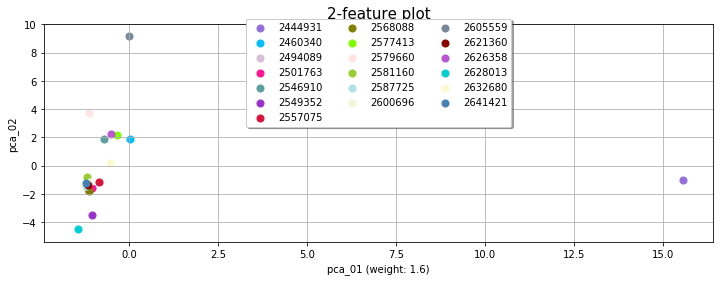

In [40]:
%matplotlib inline
eod.feature_plot_2d(atmos_cmip_jobs)

The plot shows visually what we had determined analytically in our PCA analysis, namely
`2444931` and `2505559` are most likely to be outliers.

## <a name="trained-models-pca">PCA-based Trained Models</a>

In the example above we used only the default features. Since we don't know what
features are important PCA can again come to the rescue. Our trained models support
automatic PCA. Let's try the same example using multimodel univariate classifiers with
PCA enabled. 

Notice, we set `pca=2` when creating the model to use automatic 2-component
PCA. We deliberately use features other than `duration` and `rdtsc_duration`.

In [41]:
FEATURES=set(eq.get_features(atmos_cmip_jobs)) - {'duration', 'rdtsc_duration'}

In [42]:
r = eq.create_refmodel(model_jobs, features=FEATURES, pca=2)

In [43]:
df, _ = eod.detect_outlier_jobs(atmos_cmip_jobs, features=FEATURES, pca=2, trained_model=r['id'])
df.sort_values('pca_weighted', ascending=False)

,jobid,pca_weighted,pca_01,pca_02
0,2444931,4.7,3,0
13,2605559,4.6,1,3
16,2628013,2.6,1,1
9,2579660,2.0,0,2
8,2577413,1.6,1,0
1,2460340,1.6,1,0
10,2581160,1.6,1,0
11,2587725,1.6,1,0
18,2641421,1.6,1,0
5,2549352,1.0,0,1


Notice that by removing `duration` from our PCA features, we reduced the outlier score of `2460340` (as it was outlier primarily on `duration` according to our earlier univariate results). 

The results show `2444931` and `2605559` are the principal outliers. This tallies with our earlier
results using PCA (without a trained model), and with our earlier univariate scores (without PCA). The multivariate results are also consistent once we realize that we used `duration` as a feature for MVOD scoring, and
that pushed up the MVOD scores of `2460340`.

# <a name="epmt-exp-explore">EPMT Explore API</a> 

You might be feeling manually figuring outliers one component at a time
is tedious and slow. We have some more powerful API calls that can help.

The EPMT Explore API makes it easy to compare jobs within an experiment across different
time-segments (sharing the same component).

In [44]:
# we need to import a separate library for exploring into experiments
import epmt_exp_explore as exp_explore

In [45]:
# this call gives a list sorted by the top components ordered by decreasing order
# of a metric summed across all the jobs of a metric. Here we choose the metric
# to be 'duration' and limit to the top-5 components.
# The best part is that the call already gives outliers scores. A score
# greater than 0 means the corresponding job is an outlier. The higher the score
# the higher the chance the job is an outlier. 
exp_explore.exp_component_outliers('ESM4_hist-piAer_D1', metric = 'duration', limit=5) 

[{'exp_component': 'atmos_cmip',
  'exp_times': ['18540101',
   '18590101',
   '18640101',
   '18690101',
   '18740101',
   '18790101',
   '18840101',
   '18890101',
   '18940101',
   '18990101',
   '19040101',
   '19090101',
   '19140101',
   '19190101',
   '19240101',
   '19290101',
   '19340101',
   '19390101',
   '19440101'],
  'jobids': ['2444931',
   '2460340',
   '2494089',
   '2501763',
   '2546910',
   '2549352',
   '2557075',
   '2568088',
   '2577413',
   '2579660',
   '2581160',
   '2587725',
   '2600696',
   '2605559',
   '2621360',
   '2626358',
   '2628013',
   '2632680',
   '2641421'],
  'metrics': array([3.28558294e+10, 2.04199143e+11, 2.92364000e+10, 2.36867758e+10,
         2.35996094e+10, 2.83514334e+10, 3.70291354e+10, 3.22422714e+10,
         2.22757602e+10, 2.24129515e+10, 2.77248308e+10, 3.44615325e+10,
         2.37043384e+10, 1.83414715e+10, 3.62620190e+10, 2.11224179e+10,
         4.40920051e+10, 2.39348319e+10, 3.87362813e+10]),
  'outlier_scores': array([0.

There is a lot of data above, so let's go through it carefully. For each component
(again ordered by the longest first), we have `exp_times`, `jobids`, `metrics` and
`outlier_scores`. The arrays have the same length and are correspondingly ordered.

Most interesting in this data is that it's always the second job in each component
that's an outlier. This corresponds to the time-segment `18590101` being an outlier
time-segment as a whole! 